# Zooplankton timeseries from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['zoo_prod_zint','graze_diat_zint','graze_sp_zint','NPP_diat','NPP_sp','spC_zint','diatC_zint','zooC_zint']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)


zoo_prod_zint
graze_diat_zint
graze_sp_zint
NPP_diat
NPP_sp
spC_zint
diatC_zint
zooC_zint
CPU times: user 945 ms, sys: 55.8 ms, total: 1 s
Wall time: 2.02 s


In [3]:
ds['mesozooC'] = ds.zooC_zint * (ds.diatC_zint/(ds.diatC_zint + ds.spC_zint))
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

### get pop grid

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')

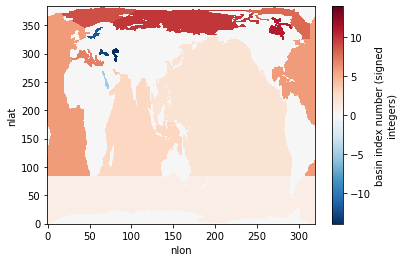

In [5]:
grid.REGION_MASK.plot()

In [6]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [7]:
ds = ds.where(grid.REGION_MASK>0)

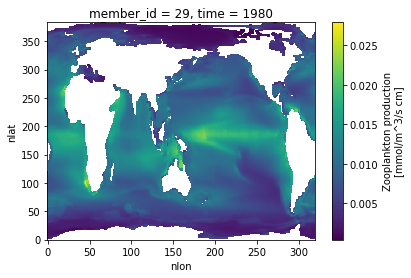

In [8]:
ds.zoo_prod_zint.isel(time=60,member_id=22).plot()

### Extract 1920s

In [9]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [10]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 1990s

In [11]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [12]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [13]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [14]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### get masks for making averages

In [15]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [16]:
variables = variables + ['mesozooC']

### ACC

In [17]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


zoo_prod_zint
graze_diat_zint
graze_sp_zint
NPP_diat
NPP_sp
spC_zint
diatC_zint
zooC_zint
mesozooC
CPU times: user 2min 54s, sys: 6min 21s, total: 9min 15s
Wall time: 16min 22s


### SIZ

In [18]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

zoo_prod_zint
graze_diat_zint
graze_sp_zint
NPP_diat
NPP_sp
spC_zint
diatC_zint
zooC_zint
mesozooC
CPU times: user 2min 34s, sys: 5min 27s, total: 8min 2s
Wall time: 15min 26s


In [19]:
ts_ACC_ens_mean = ts_ACC.mean(dim='member_id')
ts_SIZ_ens_mean = ts_SIZ.mean(dim='member_id')

In [20]:
ts_ACC_ens_mean

<xarray.Dataset>
Dimensions:          (time: 181)
Coordinates:
  * time             (time) int64 1920 1921 1922 1923 ... 2097 2098 2099 2100
Data variables:
    zoo_prod_zint    (time) float64 0.005899 0.005925 ... 0.00648 0.006493
    graze_diat_zint  (time) float64 0.007248 0.007645 ... 0.01023 0.0103
    graze_sp_zint    (time) float64 0.01241 0.01211 0.01205 ... 0.01137 0.01135
    NPP_diat         (time) float64 0.01079 0.01144 0.0116 ... 0.0149 0.01511
    NPP_sp           (time) float64 0.01561 0.01514 0.0152 ... 0.01362 0.01358
    spC_zint         (time) float64 78.17 75.82 76.46 75.6 ... 56.91 56.66 56.34
    diatC_zint       (time) float64 60.93 64.17 65.27 ... 68.49 68.53 68.93
    zooC_zint        (time) float64 88.91 89.5 89.5 89.47 ... 83.85 83.74 83.65
    mesozooC         (time) float64 37.32 38.88 39.06 39.05 ... 43.08 43.2 43.29

In [21]:
ens_mean_1920s = ds_1920s.mean(dim='member_id')

In [22]:
ens_mean_1990s = ds_1990s.mean(dim='member_id')

In [23]:
ens_mean_2090s = ds_2090s.mean(dim='member_id')

In [24]:
convert = 0.01 * 86400. # to convert from mmol/m3 cm/s to mmol/m2/d

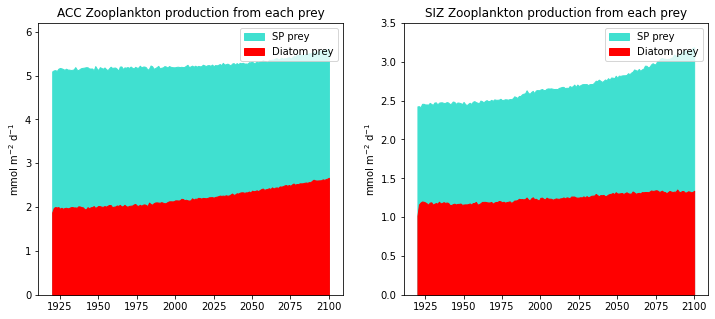

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

#### ACC
ax[0].set_title('ACC Zooplankton production from each prey')
ax[0].set_ylabel('mmol m$^{-2}$ d$^{-1}$')
ax[0].set_ylim(0,6.2)


ax[0].fill_between(years, 0, ts_ACC_ens_mean['zoo_prod_zint']*convert, color='turquoise', alpha=1, label='SP prey')
ax[0].fill_between(years, 0, ts_ACC_ens_mean['graze_diat_zint']*convert*0.3, color='red', alpha=1, label='Diatom prey')
ax[0].legend()

#### SIZ
ax[1].set_title('SIZ Zooplankton production from each prey')
ax[1].set_ylabel('mmol m$^{-2}$ d$^{-1}$')
ax[1].set_ylim(0,3.5)


ax[1].fill_between(years, 0, ts_SIZ_ens_mean['zoo_prod_zint']*convert, color='turquoise', alpha=1, label='SP prey')
ax[1].fill_between(years, 0, ts_SIZ_ens_mean['graze_diat_zint']*convert*0.3, color='red', alpha=1, label='Diatom prey')
ax[1].legend();


In [27]:
zoo_1920s = ts_SIZ_ens_mean['zoo_prod_zint'].isel(time=slice(0,10)).mean(dim='time')*convert
diat_1920s = ts_SIZ_ens_mean['graze_diat_zint'].isel(time=slice(0,10)).mean(dim='time')*convert*0.3
sp_1920s = zoo_1920s - diat_1920s  
              
diat_2090s = ts_SIZ_ens_mean['graze_diat_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert*0.3
zoo_2090s = ts_SIZ_ens_mean['zoo_prod_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert
sp_2090s = zoo_2090s - diat_2090s

In [28]:
zoo_1920s.values

array(2.44713228)

In [29]:
diat_1920s.values

array(1.16760625)

In [30]:
sp_1920s.values

array(1.27952603)

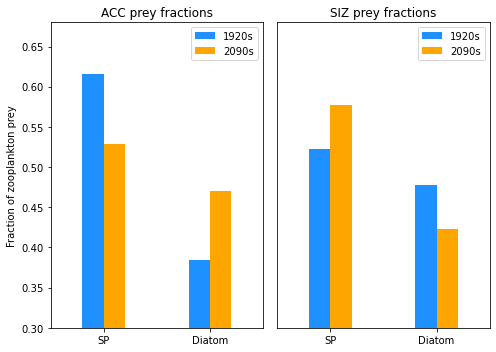

In [31]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(7,5))

#ACC
labels = ['SP','Diatom']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax[0].set_xlim(-0.5,1.5)
ax[0].set_ylim(0.3,0.68)

zoo_1920s = ts_ACC_ens_mean['zoo_prod_zint'].isel(time=slice(0,10)).mean(dim='time')*convert
diat_1920s = ts_ACC_ens_mean['graze_diat_zint'].isel(time=slice(0,10)).mean(dim='time')*convert*0.3
sp_1920s = zoo_1920s - diat_1920s  
              
diat_2090s = ts_ACC_ens_mean['graze_diat_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert*0.3
zoo_2090s = ts_ACC_ens_mean['zoo_prod_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert
sp_2090s = zoo_2090s - diat_2090s

fracs_1920s = [sp_1920s/zoo_1920s,diat_1920s/zoo_1920s]
fracs_2090s = [sp_2090s/zoo_2090s,diat_2090s/zoo_2090s]

rects1 = ax[0].bar(xvals - width/2, fracs_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[0].bar(xvals + width/2, fracs_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Fraction of zooplankton prey')
ax[0].set_title('ACC prey fractions')
ax[0].set_xticks(xvals)
ax[0].set_xticklabels(labels)
ax[0].legend()

#SIZ
labels = ['SP','Diatom']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax[1].set_xlim(-0.5,1.5)
ax[1].set_ylim(0.3,0.68)

zoo_1920s = ts_SIZ_ens_mean['zoo_prod_zint'].isel(time=slice(0,10)).mean(dim='time')*convert
diat_1920s = ts_SIZ_ens_mean['graze_diat_zint'].isel(time=slice(0,10)).mean(dim='time')*convert*0.3
sp_1920s = zoo_1920s - diat_1920s  
              
diat_2090s = ts_SIZ_ens_mean['graze_diat_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert*0.3
zoo_2090s = ts_SIZ_ens_mean['zoo_prod_zint'].isel(time=slice(-11,-1)).mean(dim='time')*convert
sp_2090s = zoo_2090s - diat_2090s

fracs_1920s = [sp_1920s/zoo_1920s,diat_1920s/zoo_1920s]
fracs_2090s = [sp_2090s/zoo_2090s,diat_2090s/zoo_2090s]

rects1 = ax[1].bar(xvals - width/2, fracs_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[1].bar(xvals + width/2, fracs_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_title('SIZ prey fractions')
ax[1].set_xticks(xvals)
ax[1].set_xticklabels(labels)
ax[1].legend()
ax[1].axes.yaxis.set_visible(False)


fig.subplots_adjust(wspace=0.05)

fig.tight_layout()

#plt.show()

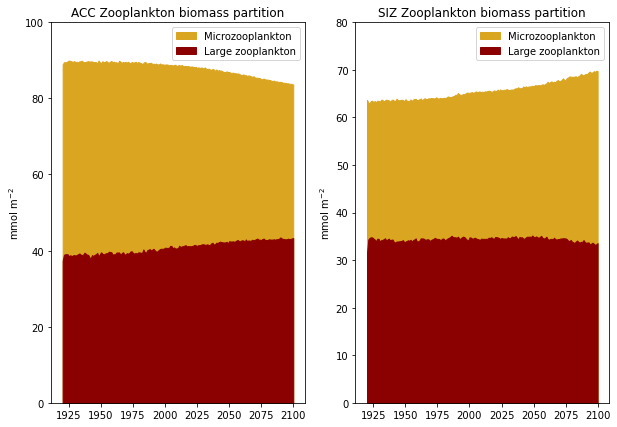

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,7))

#### ACC
ax[0].set_title('ACC Zooplankton biomass partition')
ax[0].set_ylabel('mmol m$^{-2}$')
ax[0].set_ylim(0,100)


ax[0].fill_between(years, 0, ts_ACC_ens_mean['zooC_zint'], color='goldenrod', alpha=1, label='Microzooplankton')
ax[0].fill_between(years, 0, ts_ACC_ens_mean['mesozooC'], color='darkred', alpha=1, label='Large zooplankton')
ax[0].legend()

#### SIZ
ax[1].set_title('SIZ Zooplankton biomass partition')
ax[1].set_ylabel('mmol m$^{-2}$')
ax[1].set_ylim(0,80)


ax[1].fill_between(years, 0, ts_SIZ_ens_mean['zooC_zint'], color='goldenrod', alpha=1, label='Microzooplankton')
ax[1].fill_between(years, 0, ts_SIZ_ens_mean['mesozooC'], color='darkred', alpha=1, label='Large zooplankton')
ax[1].legend();
